아주 간단한 Audio Tujtorial 입니다. 딥러닝 초반의 MNIST 와 같습니다.

##설정

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### Speech Commands 데이터 세트 가져 오기

Speech Commands(https://www.tensorflow.org/datasets/catalog/speech_commands) 데이터 세트 의 일부를 다운로드하는 스크립트를 작성합니다. 원래 데이터 세트는 30 개의 다른 단어를 말하는 사람들의 105,000 개 이상의 WAV 오디오 파일로 구성됩니다. 이 데이터는 Google에서 수집하고 CC BY 라이선스에 따라 공개되었습니다.

In [2]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182083584/182082353 [==============================] - 1s 0us/step


데이터 세트에 대한 기본 통계를 확인합니다.

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['go' 'no' 'stop' 'yes' 'up' 'right' 'left' 'down']


오디오 파일을 목록으로 추출하고 섞습니다.

In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/right/340c8b10_nohash_0.wav', shape=(), dtype=string)


각각 80:10:10 비율을 사용하여 파일을 학습, 검증 및 테스트 세트로 분할합니다.

In [5]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


오디오 파일 및 레이블 읽기
오디오 파일은 처음에는 이진 파일로 읽혀지며 숫자 텐서로 변환 할 수 있습니다.

오디오 파일을로드하려면 WAV 인코딩 오디오를 Tensor 및 샘플 속도로 반환하는 tf.audio.decode_wav 를 사용합니다.

WAV 파일에는 초당 샘플 수가 설정된 시계열 데이터가 포함됩니다. 각 샘플은 특정 시간에 오디오 신호의 진폭을 나타냅니다. mini_speech_commands 의 파일과 같이 16 비트 시스템에서 값의 범위는 -32768에서 32767입니다.이 데이터 세트의 샘플 속도는 16kHz입니다. tf.audio.decode_wav 는 값을 [-1.0, 1.0] 범위로 정규화합니다.

In [6]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

각 WAV 파일의 레이블은 상위 디렉토리입니다.

In [7]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

WAV 파일의 파일 이름을 가져와 감독 교육을위한 오디오 및 레이블이 포함 된 튜플을 출력하는 방법을 정의 해 보겠습니다.

In [8]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

이제 process_path 를 적용하여 오디오 레이블 쌍을 추출하고 결과를 확인하는 훈련 세트를 빌드합니다. 나중에 유사한 절차를 사용하여 유효성 검사 및 테스트 세트를 빌드합니다.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

해당 레이블이있는 몇 가지 오디오 파형을 살펴 보겠습니다.

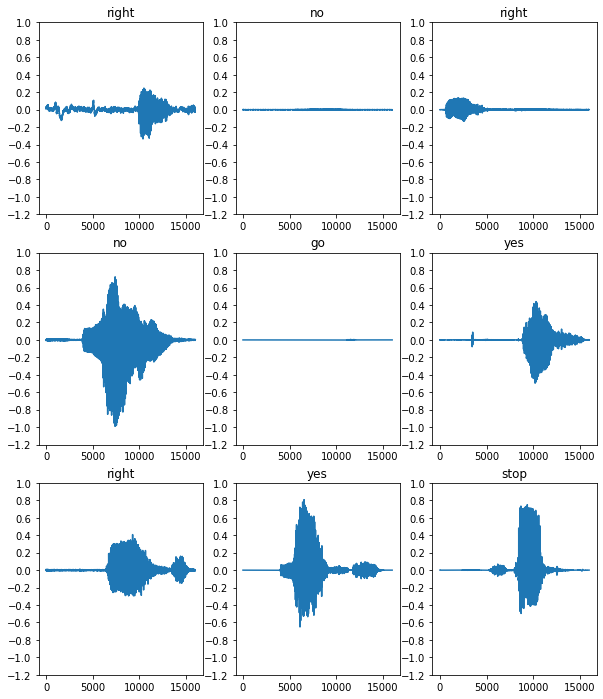

In [10]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

스펙트로 그램
파형을 스펙트로 그램으로 변환하여 시간에 따른 주파수 변화를 보여주고 2D 이미지로 표현할 수 있습니다. 이는 단시간 푸리에 변환 (STFT)을 적용하여 오디오를 시간-주파수 도메인으로 변환함으로써 수행 할 수 있습니다.

푸리에 변환 ( tf.signal.fft )은 신호를 구성 주파수로 변환하지만 모든 시간 정보를 잃습니다. STFT ( tf.signal.stft )는 신호를 시간 창으로 분할하고 각 창에서 푸리에 변환을 실행하여 일부 시간 정보를 보존하고 표준 컨볼 루션을 실행할 수있는 2D 텐서를 반환합니다.

STFT는 크기와 위상을 나타내는 복소수의 배열을 생성합니다. 그러나 tf.abs 의 출력에 tf.signal.stft 적용하여 파생 될 수있는이 자습서의 크기 만 필요합니다.

생성 된 스펙트로 그램 "이미지"가 거의 정사각형이되도록 frame_length 및 frame_step 매개 변수를 선택합니다. STFT 매개 변수 선택에 대한 자세한 내용은 오디오 신호 처리에 대한 이 비디오 를 참조하십시오.

또한 파형의 길이가 같으면 스펙트로 그램 이미지로 변환 할 때 결과가 비슷한 치수를 갖게됩니다. 이것은 1 초보다 짧은 오디오 클립을 0으로 채우기 만하면됩니다.

In [11]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

다음으로 데이터를 탐색합니다. 파형, 스펙트로 그램 및 데이터 세트에서 한 예의 실제 오디오를 비교합니다.

In [12]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


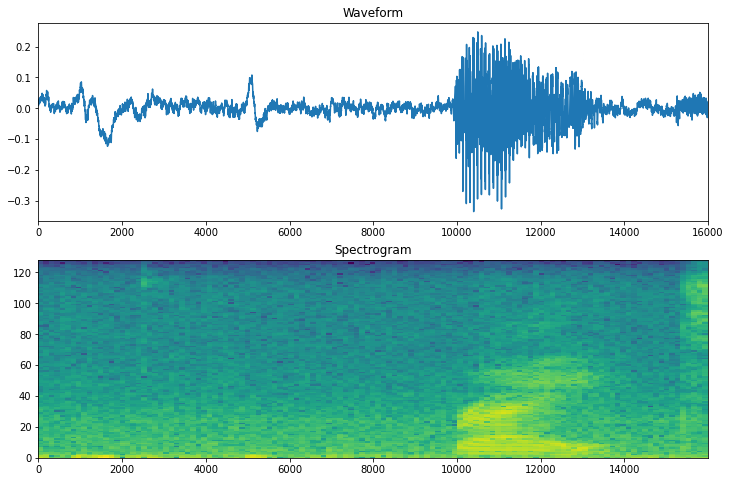

In [13]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

이제 스펙트로 그램 이미지와 해당 레이블을 정수 ID로 갖도록 파형 데이터 세트를 변환하십시오.

In [14]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [15]:
spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

데이터 세트의 다른 샘플에 대한 스펙트로 그램 "이미지"를 조사합니다.

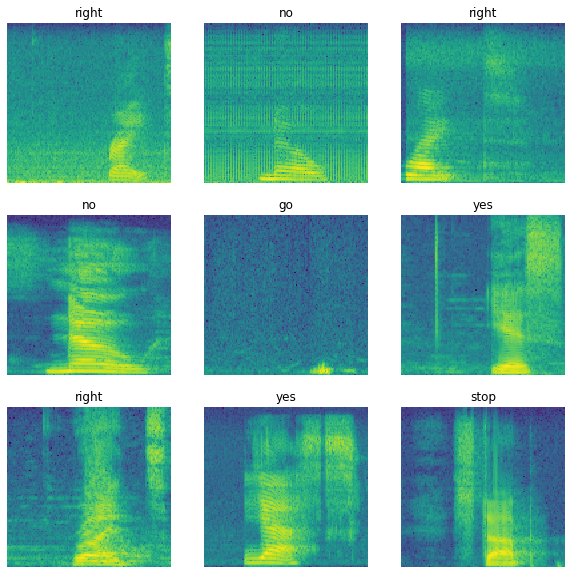

In [16]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

### 모델 구축 및 훈련


이제 모델을 구축하고 훈련 할 수 있습니다. 그러나 그렇게하기 전에 검증 및 테스트 세트에 대해 학습 세트 전처리를 반복해야합니다.

In [17]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [18]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

모델 학습을위한 학습 및 검증 세트를 일괄 처리합니다.

In [19]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

모델을 학습하는 동안 읽기 지연 시간을 줄이기 위해 데이터 세트 cache() 및 prefetch() 작업을 추가합니다.

In [20]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

모델의 경우 오디오 파일을 스펙트로 그램 이미지로 변환 했으므로 간단한 CNN (Convolutional Neural Network)을 사용합니다. 모델에는 다음과 같은 추가 전처리 레이어도 있습니다.

- 모델이 더 빠르게 학습 할 수 있도록 입력을 다운 샘플링하는 Resizing 레이어.

- 평균 및 표준 편차를 기반으로 이미지의 각 픽셀을 정규화하는 Normalization 레이어입니다.

Normalization 계층의 경우 집계 통계 (즉, 평균 및 표준 편차)를 계산하기 위해 먼저 훈련 데이터에서 adapt 메서드를 호출해야합니다.

In [21]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [23]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 49s 176ms/step - loss: 1.7350 - accuracy: 0.3805 - val_loss: 1.2677 - val_accuracy: 0.5738
Epoch 2/10
100/100 [==============================] - 1s 8ms/step - loss: 1.1969 - accuracy: 0.5734 - val_loss: 0.9533 - val_accuracy: 0.6850
Epoch 3/10
100/100 [==============================] - 1s 7ms/step - loss: 0.9178 - accuracy: 0.6728 - val_loss: 0.7868 - val_accuracy: 0.7387
Epoch 4/10
100/100 [==============================] - 1s 7ms/step - loss: 0.7534 - accuracy: 0.7317 - val_loss: 0.7020 - val_accuracy: 0.7650
Epoch 5/10
100/100 [==============================] - 1s 7ms/step - loss: 0.6598 - accuracy: 0.7597 - val_loss: 0.6386 - val_accuracy: 0.7837
Epoch 6/10
100/100 [==============================] - 1s 7ms/step - loss: 0.5546 - accuracy: 0.7977 - val_loss: 0.5932 - val_accuracy: 0.7862
Epoch 7/10
100/100 [==============================] - 1s 7ms/step - loss: 0.5037 - accuracy: 0.8164 - val_loss: 0.5996 - val_accuracy: 0.8100
Epo

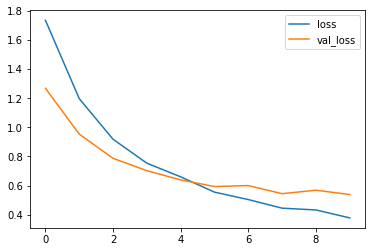

In [24]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

#### 테스트 세트 성능 평가


테스트 세트에서 모델을 실행하고 성능을 확인합시다.

학습 및 검증 손실 곡선을 확인하여 학습 중에 모델이 어떻게 개선되었는지 살펴 보겠습니다.

In [25]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [26]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 82%


####혼동 행렬 표시


혼동 행렬은 테스트 세트의 각 명령에서 모델이 얼마나 잘 수행했는지 확인하는 데 유용합니다.

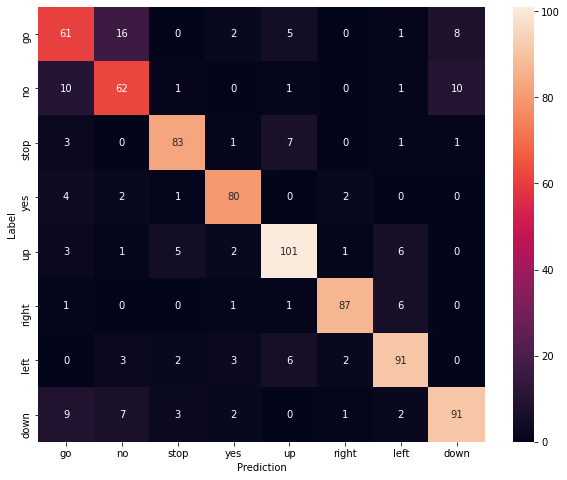

In [27]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

#### 오디오 파일에서 추론 실행
마지막으로 "아니오"라고 말하는 사람의 입력 오디오 파일을 사용하여 모델의 예측 출력을 확인합니다. 모델이 얼마나 잘 작동합니까?

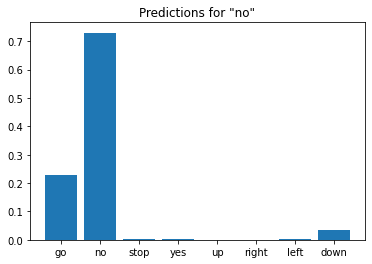

In [28]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

모델이 오디오 명령을 "아니요"로 매우 명확하게 인식했음을 알 수 있습니다.

## 환경 소리 분류를 위해 YAMNet을 사용한 전이 학습

YAMNet(https://tfhub.dev/google/yamnet/1) 은 웃음, 짖는 소리 또는 사이렌과 같은 521 개(https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv) 클래스의 오디오 이벤트를 예측할 수있는 사전 훈련 된 심층 신경망입니다.

이 자습서에서는 다음 방법을 학습합니다.

추론을 위해 YAMNet 모델을로드하고 사용합니다.
YAMNet 임베딩을 사용하여 고양이와 개 소리를 분류하는 새 모델을 만듭니다.
모델을 평가하고 내 보냅니다.

TensorFlow 및 기타 라이브러리 가져 오기


먼저 TensorFlow I / O 를 설치하면 디스크에서 오디오 파일을 더 쉽게로드 할 수 있습니다.

In [29]:
!pip install tensorflow_io

     |████████████████████████████████| 22.7 MB 1.6 MB/s 
     |████████████████████████████████| 2.3 MB 50.6 MB/s 


In [30]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

YAMNet 정보
YAMNet(https://github.com/tensorflow/models/tree/master/research/audioset/yamnet) 은 MobileNetV1(https://arxiv.org/abs/1704.04861) 심도 분리형 컨볼 루션 아키텍처를 사용하는 사전 훈련 된 신경망입니다. 오디오 파형을 입력으로 사용하고 AudioSet 코퍼스(https://research.google.com/audioset/)의 521 오디오 이벤트 각각에 대해 독립적 인 예측을 할 수 있습니다.

내부적으로 모델은 오디오 신호에서 "프레임"을 추출하고 이러한 프레임의 배치를 처리합니다. 이 모델 버전은 0.96 초 길이의 프레임을 사용하고 0.48 초마다 한 프레임을 추출합니다.

모델은 [-1.0, +1.0] 범위의 단일 채널 (모노) 16kHz 샘플로 표현되는 임의 길이의 파형을 포함하는 1D float32 Tensor 또는 NumPy 배열을받습니다. 이 자습서에는 WAV 파일을 지원되는 형식으로 변환하는 데 도움이되는 코드가 포함되어 있습니다.

모델은 클래스 점수, 임베딩 (전이 학습에 사용) 및 log mel 스펙트로 그램을 포함하여 3 개의 출력을 반환합니다. 여기(https://tfhub.dev/google/yamnet/1)에서 자세한 내용을 확인할 수 있습니다.

YAMNet의 특정 용도 중 하나는 1,024 차원 임베딩 출력 인 고수준 기능 추출기입니다. 기본 (YAMNet) 모델의 입력 기능을 사용하고 숨겨진 tf.keras.layers.Dense 레이어로 구성된 더 얕은 모델에 입력합니다. 그런 다음 레이블이 지정된 많은 데이터와 종단 간 교육 없이 오디오 분류 를 위해 소량의 데이터로 네트워크를 교육합니다. (자세한 내용 은 TensorFlow Hub(https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) 를 사용한 이미지 분류를위한 전이 학습 과 유사합니다.)

먼저 모델을 테스트하고 오디오 분류 결과를 확인합니다. 그런 다음 데이터 사전 처리 파이프 라인을 구성합니다.

TensorFlow Hub에서 YAMNet로드
Tensorflow Hub 에서 사전 학습 된 YAMNet을 사용하여 사운드 파일에서 임베딩을 추출합니다.

TensorFlow Hub에서 모델을로드하는 것은 간단합니다. 모델을 선택하고 해당 URL을 복사하고 load 기능을 사용합니다.

In [31]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

모델이로드되면 YAMNet 기본 사용 자습서(https://www.tensorflow.org/hub/tutorials/yamnet)를 따르고 샘플 WAV 파일을 다운로드하여 추론을 실행할 수 있습니다.

In [32]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

221184/215546 [==============================] - 0s 0us/step
./test_data/miaow_16k.wav


오디오 파일을로드하는 기능이 필요하며, 이는 나중에 훈련 데이터로 작업 할 때도 사용됩니다. ( 단순 오디오 인식 에서 오디오 파일 및 레이블 읽기에 대해 자세히 알아보십시오.

In [33]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


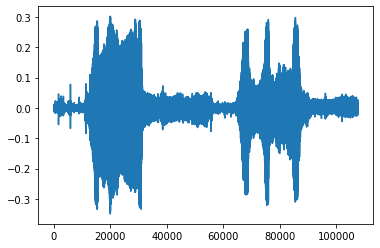

In [34]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data,rate=16000)

####클래스 매핑로드


YAMNet이 인식 할 수있는 클래스 이름을로드하는 것이 중요합니다. 매핑 파일은 CSV 형식으로 yamnet_model.class_map_path() 에 있습니다.

In [35]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


####추론 실행


YAMNet은 프레임 수준의 클래스 점수 (즉, 모든 프레임에 대해 521 개의 점수)를 제공합니다. 클립 레벨 예측을 결정하기 위해, 점수는 프레임에 걸쳐 클래스별로 집계 될 수 있습니다 (예 : 평균 또는 최대 집계 사용). 이것은 scores_np.mean(axis=0) 의해 수행됩니다. 마지막으로 클립 수준에서 최고 점수를받은 클래스를 찾으려면 최대 521 개의 집계 점수를 가져옵니다.

In [36]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Animal
The embeddings shape: (13, 1024)


ESC-50 데이터 세트
ESC-50 데이터 세트 ( Piczak, 2015 )(https://github.com/karolpiczak/ESC-50#repository-content)는 5 초 길이의 환경 오디오 녹음 2,000 개의 레이블이있는 컬렉션입니다. 데이터 세트는 50 개의 클래스로 구성되며 클래스 당 40 개의 예제가 있습니다.

데이터 세트를 다운로드하고 추출합니다.

In [37]:
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

645701632/Unknown - 43s 0us/step

###데이터 탐색


각 파일의 메타 데이터는 ./datasets/ESC-50-master/meta/esc50.csv 의 csv 파일에 지정됩니다.

모든 오디오 파일은 ./datasets/ESC-50-master/audio/

매핑으로 pandas DataFrame 을 만들고이를 사용하여 데이터를 더 명확하게 볼 수 있습니다.

In [38]:
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


####데이터 필터링


이제 데이터가 DataFrame 저장 DataFrame 몇 가지 변환을 적용합니다.

행을 필터링하고 선택한 클래스 ( dog 및 cat 만 사용합니다. 다른 클래스를 사용하려면 여기에서 선택할 수 있습니다.
전체 경로를 갖도록 파일 이름을 수정하십시오. 이렇게하면 나중에 쉽게로드 할 수 있습니다.
목표를 특정 범위 내에 있도록 변경하십시오. 이 예에서 dog 는 0 유지되지만 cat 은 원래 값인 5 대신 1 됩니다.

In [39]:
my_classes = ['dog', 'cat']
map_class_to_id = {'dog':0, 'cat':1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
0,./datasets/ESC-50-master/audio/1-100032-A-0.wav,1,0,dog,True,100032,A
14,./datasets/ESC-50-master/audio/1-110389-A-0.wav,1,0,dog,True,110389,A
157,./datasets/ESC-50-master/audio/1-30226-A-0.wav,1,0,dog,True,30226,A
158,./datasets/ESC-50-master/audio/1-30344-A-0.wav,1,0,dog,True,30344,A
170,./datasets/ESC-50-master/audio/1-32318-A-0.wav,1,0,dog,True,32318,A
175,./datasets/ESC-50-master/audio/1-34094-A-5.wav,1,1,cat,False,34094,A
176,./datasets/ESC-50-master/audio/1-34094-B-5.wav,1,1,cat,False,34094,B
229,./datasets/ESC-50-master/audio/1-47819-A-5.wav,1,1,cat,False,47819,A
230,./datasets/ESC-50-master/audio/1-47819-B-5.wav,1,1,cat,False,47819,B
231,./datasets/ESC-50-master/audio/1-47819-C-5.wav,1,1,cat,False,47819,C


####오디오 파일을로드하고 임베딩 검색


여기서 load_wav_16k_mono 적용하고 모델에 대한 WAV 데이터를 준비합니다.

WAV 데이터에서 임베딩을 추출 할 때 형태 배열 (N, 1024) 을 얻습니다. 여기서 N 은 YAMNet이 찾은 프레임 수입니다 (오디오 0.48 초마다 하나씩).

모델은 각 프레임을 하나의 입력으로 사용합니다. 따라서 행당 하나의 프레임이있는 새 열을 만들어야합니다. 또한 이러한 새 행을 적절하게 반영하도록 레이블과 fold 열을 확장해야합니다.

펼쳐진 fold 열은 원래 값을 유지합니다. 분할을 수행 할 때 다른 분할에서 동일한 오디오의 일부를 갖게되어 유효성 검사 및 테스트 단계의 효율성이 떨어질 수 있으므로 프레임을 혼합 할 수 없습니다.

In [43]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [44]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [46]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

#### 데이터 분할

fold 열을 사용하여 데이터 세트를 학습, 검증 및 테스트 세트로 분할합니다.

ESC-50은 동일한 원본 소스의 클립이 항상 동일한 fold 에 있도록 5 개의 균일 한 크기의 교차 검증 fold 로 배열됩니다. 자세한 내용은 ESC : 환경 소리 분류를위한 데이터 세트 문서에서 확인하세요.

마지막 단계는 학습 중에 사용하지 않을 것이므로 데이터 세트에서 fold 열을 제거하는 것입니다.

In [48]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

####모델 만들기


대부분의 작업을 수행했습니다! 다음으로, 소리에서 고양이와 개를 인식하기 위해 하나의 히든 레이어와 두 개의 출력으로 매우 간단한 순차 모델을 정의합니다.

In [49]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [50]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [51]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
15/15 [==============================] - 8s 36ms/step - loss: 1.1728 - accuracy: 0.8396 - val_loss: 1.5792 - val_accuracy: 0.8687
Epoch 2/20
15/15 [==============================] - 0s 28ms/step - loss: 0.4979 - accuracy: 0.9000 - val_loss: 0.2408 - val_accuracy: 0.8875
Epoch 3/20
15/15 [==============================] - 0s 29ms/step - loss: 0.2678 - accuracy: 0.9042 - val_loss: 0.2184 - val_accuracy: 0.8875
Epoch 4/20
15/15 [==============================] - 0s 32ms/step - loss: 0.2607 - accuracy: 0.8979 - val_loss: 0.3182 - val_accuracy: 0.8625
Epoch 5/20
15/15 [==============================] - 0s 26ms/step - loss: 0.3682 - accuracy: 0.9229 - val_loss: 0.2175 - val_accuracy: 0.9125
Epoch 6/20
15/15 [==============================] - 0s 32ms/step - loss: 0.2546 - accuracy: 0.9271 - val_loss: 0.7720 - val_accuracy: 0.8750
Epoch 7/20
15/15 [==============================] - 0s 31ms/step - loss: 0.3050 - accuracy: 0.9187 - val_loss: 0.2205 - val_accuracy: 0.9125
Epoch 8/20
15

과적 합이 없는지 확인하기 위해 테스트 데이터에 대해 evaluate 방법을 실행 해 보겠습니다.

In [52]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

5/5 [==============================] - 0s 6ms/step - loss: 0.4835 - accuracy: 0.8062
Loss:  0.4834887385368347
Accuracy:  0.8062499761581421


####모델 테스트


다음으로, YAMNet만을 사용하여 이전 테스트의 임베딩에서 모델을 시도하십시오.

In [53]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: cat


#### WAV 파일을 입력으로 직접 가져올 수있는 모델 저장


임베딩을 입력으로 제공하면 모델이 작동합니다.

실제 시나리오에서는 오디오 데이터를 직접 입력으로 사용하고 싶을 것입니다.

이를 위해 YAMNet을 모델과 결합하여 다른 애플리케이션 용으로 내보낼 수있는 단일 모델로 결합합니다.

모델의 결과를보다 쉽게 ​​사용할 수 있도록 최종 레이어는 reduce_mean 작업입니다. 이 모델을 제공에 사용하는 경우 (이 자습서의 뒷부분에서 배우게 됨) 최종 레이어의 이름이 필요합니다. 하나를 정의하지 않으면 TensorFlow는 모델을 학습 할 때마다 계속 변경되므로 테스트하기 어렵게 만드는 증분 항목을 자동 정의합니다. 원시 TensorFlow 작업을 사용하는 경우 이름을 할당 할 수 없습니다. 이 문제를 해결하기 위해 reduce_mean 을 적용하는 사용자 지정 레이어를 만들고 'classifier' 합니다.

In [54]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [55]:
saved_model_path = './dogs_and_cats_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet/assets


INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet/assets


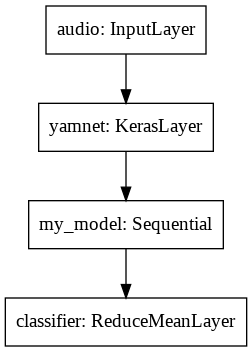

In [56]:
tf.keras.utils.plot_model(serving_model)

저장된 모델을로드하여 예상대로 작동하는지 확인합니다.

In [57]:
reloaded_model = tf.saved_model.load(saved_model_path)

그리고 최종 테스트 : 일부 사운드 데이터가 주어지면 모델이 올바른 결과를 반환합니까?

In [58]:
reloaded_results = reloaded_model(testing_wav_data)
cat_or_dog = my_classes[tf.argmax(reloaded_results)]
print(f'The main sound is: {cat_or_dog}')

The main sound is: cat


서빙 설정에서 새 모델을 시도하려면 'serving_default'서명을 사용할 수 있습니다.

In [59]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
cat_or_dog = my_classes[tf.argmax(serving_results['classifier'])]
print(f'The main sound is: {cat_or_dog}')

The main sound is: cat


####(선택 사항) 추가 테스트


모델이 준비되었습니다.

테스트 데이터 셋에서 YAMNet과 비교해 봅시다.

./datasets/ESC-50-master/audio/5-169983-A-5.wav


Waveform values: [-5.5530812e-08  1.5579258e-07 -1.3647924e-07 ... -1.0891285e-02
 -1.0113415e-02 -9.4338730e-03]


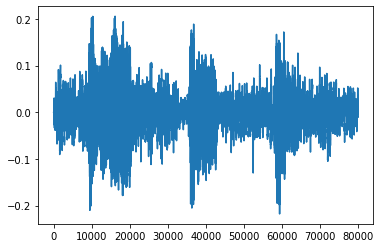

In [60]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 5]
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [63]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
inferred_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is: {inferred_class} ({top_score})')

reloaded_results = reloaded_model(waveform)
your_top_class = tf.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score}')

[YAMNet] The main sound is: Animal (0.583882212638855)
[Your model] The main sound is: cat (0.9978567957878113


참고 : 인공지능 Deep voice를 이용한 TTS(음성합성) 구현하기 _ 손석희 앵커(http://melonicedlatte.com/machinelearning/2018/07/02/215933.html)

참고 : 내 목소리로 TTS(Text to Speech) 만들기(https://sce-tts.github.io/#/)